# Training

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
import tqdm

import matplotlib.pyplot as plt

In [2]:
from src.starcattovae.training.data import Data

from src.starcattovae.nn.decoder import Decoder
from src.starcattovae.nn.encoder import Encoder
from src.starcattovae.nn.model import Model

from src.starcattovae.plotting import plot_loss
from src.starcattovae.plotting import plot_training_validation_loss
from src.starcattovae.plotting import plot_reconstruction
from src.starcattovae.plotting import plot_waveform_grid
from src.starcattovae.plotting import plot_latent_morphs

In [3]:
manualSeed = 99
np.random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # reproducibility

### Define Parameters

In [4]:
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

print(f"Using device: {DEVICE}")

# model parameters
batch_size = 32
epochs = 350

x_length = 256
hidden_dim = 512
latent_dim = 8
lr = 1e-3

Using device: mps


## Load Training Data

In [5]:
np.random.seed(42)
indices = np.arange(1684) # this is the number of signals minus all the signals with beta_IC_b less than 0
np.random.shuffle(indices)
split_ratio = 0.9
split_idx = int(len(indices) * split_ratio)
train_indices = indices[:split_idx]
validation_indices = indices[split_idx:]

# Create train and validation datasets
train_dataset = Data(indices=train_indices, train=True)
validation_dataset = Data(indices=validation_indices, train=False)

# Check for overlap
train_indices_set = set(train_dataset.get_indices())
validation_indices_set = set(validation_dataset.get_indices())

overlap = train_indices_set.intersection(validation_indices_set)
if len(overlap) == 0:
    print("Train and validation sets are different.")
else:
    print("Train and validation sets have overlap.")

Train and validation sets are different.


In [6]:
train_dataset.summary()
validation_dataset.summary()

2024-11-16 11:56:49.963 | INFO     | src.starcattovae.training.data:summary:96 - Signal Dataset mean: -0.524 +/- 39.879
Signal Dataset scaling factor (to match noise in generator): 5
Signal Dataset max value: 656.2575073242188
Signal Dataset shape: (256, 1515)

2024-11-16 11:56:49.964 | INFO     | src.starcattovae.training.data:summary:96 - Signal Dataset mean: -0.444 +/- 38.309
Signal Dataset scaling factor (to match noise in generator): 5
Signal Dataset max value: 626.9296875
Signal Dataset shape: (256, 169)



In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

## Load Autoencoders

In [8]:
encoder = Encoder(input_dim=x_length, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_length)

model = Model(Encoder=encoder, Decoder=decoder, DEVICE=DEVICE).to(DEVICE)

### Loss Function

In [9]:
def loss_function(x, x_hat, mean, log_var):
    # sse loss
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    reproduction_loss *= 1 * 256
    
    # KLD
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    # total loss
    total_loss = reproduction_loss + KLD

    return total_loss, reproduction_loss, KLD

optimizer = Adam(model.parameters(), lr=lr)

### Train VAE

Start training VAE...
Epoch 1 complete! 	Average Loss: 204.3756, Validation Loss: 130.7118
Epoch 2 complete! 	Average Loss: 108.3741, Validation Loss: 99.0407
Epoch 3 complete! 	Average Loss: 79.7442, Validation Loss: 70.0495
Epoch 4 complete! 	Average Loss: 64.2981, Validation Loss: 65.9595
Epoch 5 complete! 	Average Loss: 59.2806, Validation Loss: 60.4905
Epoch 6 complete! 	Average Loss: 53.8782, Validation Loss: 54.0488
Epoch 7 complete! 	Average Loss: 49.2244, Validation Loss: 52.1575
Epoch 8 complete! 	Average Loss: 47.4582, Validation Loss: 49.2005
Epoch 9 complete! 	Average Loss: 45.8261, Validation Loss: 49.0656
Epoch 10 complete! 	Average Loss: 44.7817, Validation Loss: 49.5620


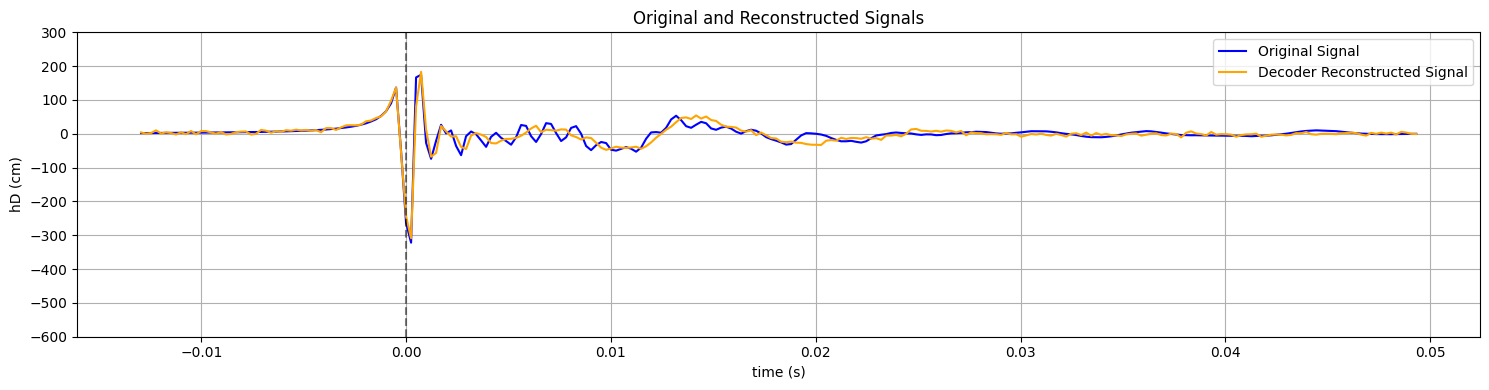

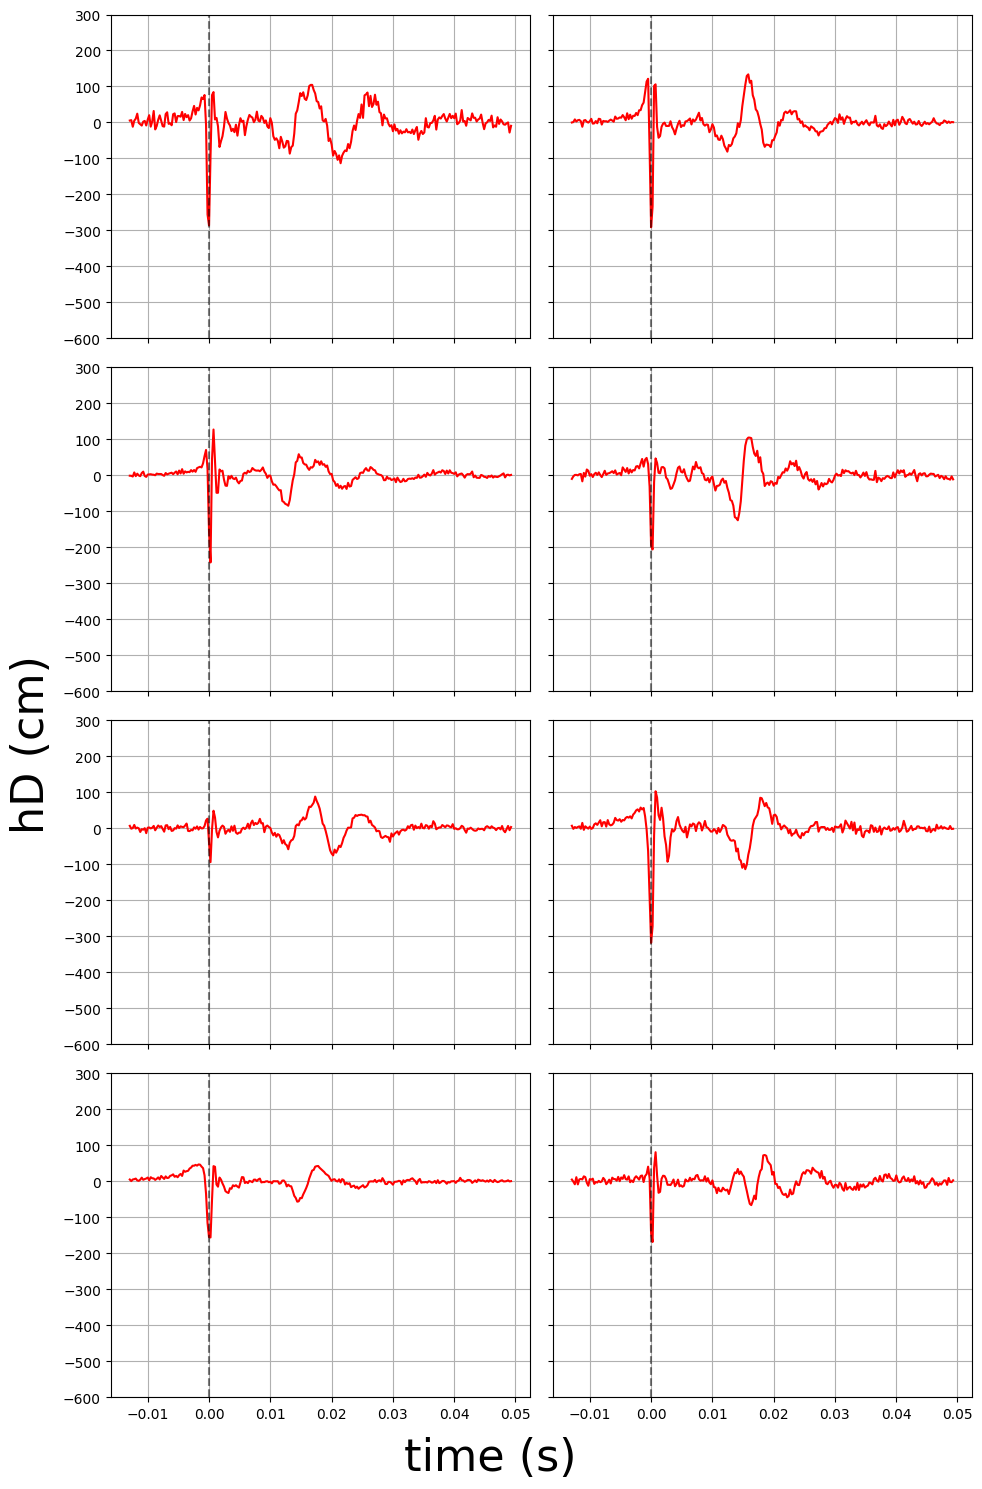

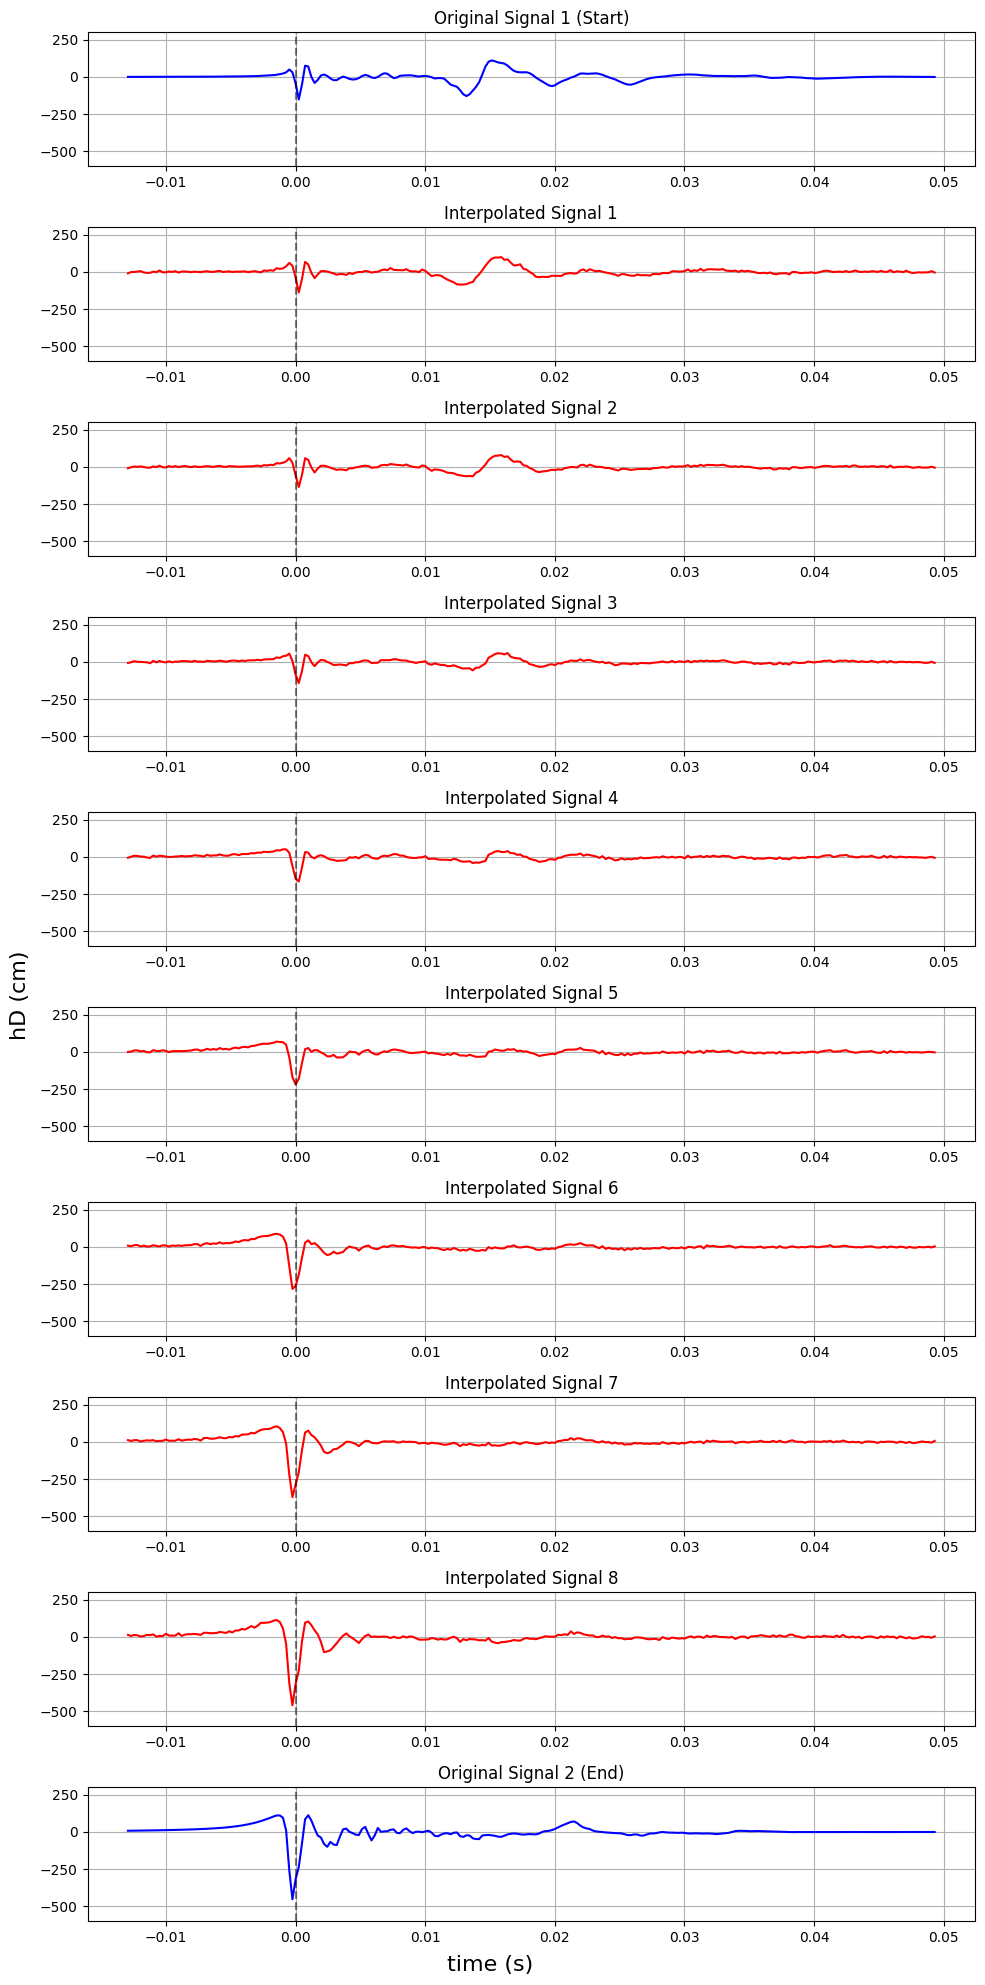

Epoch 11 complete! 	Average Loss: 44.0815, Validation Loss: 48.0561
Epoch 12 complete! 	Average Loss: 43.4977, Validation Loss: 45.8299
Epoch 13 complete! 	Average Loss: 41.8538, Validation Loss: 46.2312
Epoch 14 complete! 	Average Loss: 41.6917, Validation Loss: 46.5190
Epoch 15 complete! 	Average Loss: 41.1717, Validation Loss: 45.4357
Epoch 16 complete! 	Average Loss: 40.4028, Validation Loss: 44.7236
Epoch 17 complete! 	Average Loss: 40.2428, Validation Loss: 46.1321
Epoch 18 complete! 	Average Loss: 39.6821, Validation Loss: 44.7836
Epoch 19 complete! 	Average Loss: 39.5565, Validation Loss: 44.0896
Epoch 20 complete! 	Average Loss: 38.4943, Validation Loss: 41.9601


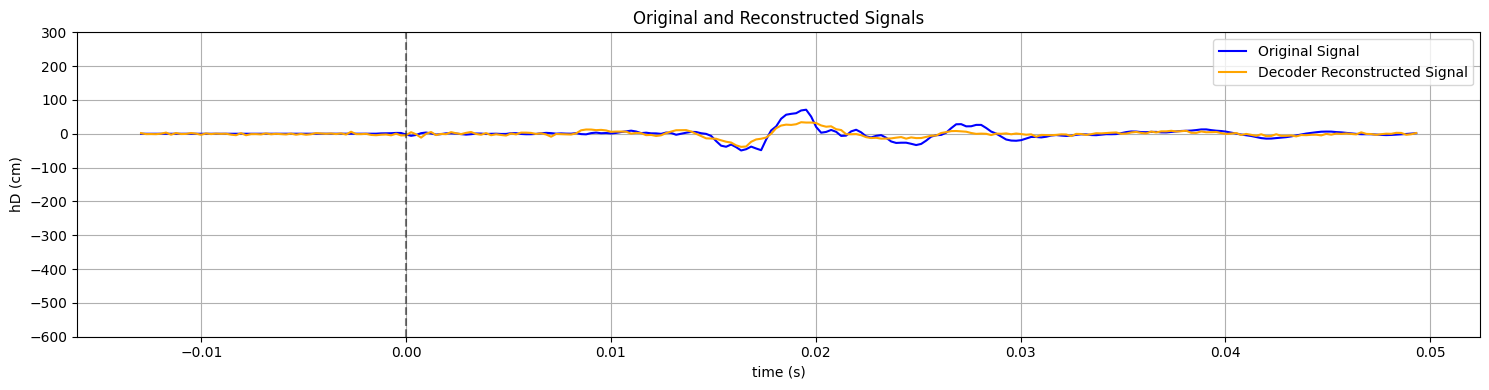

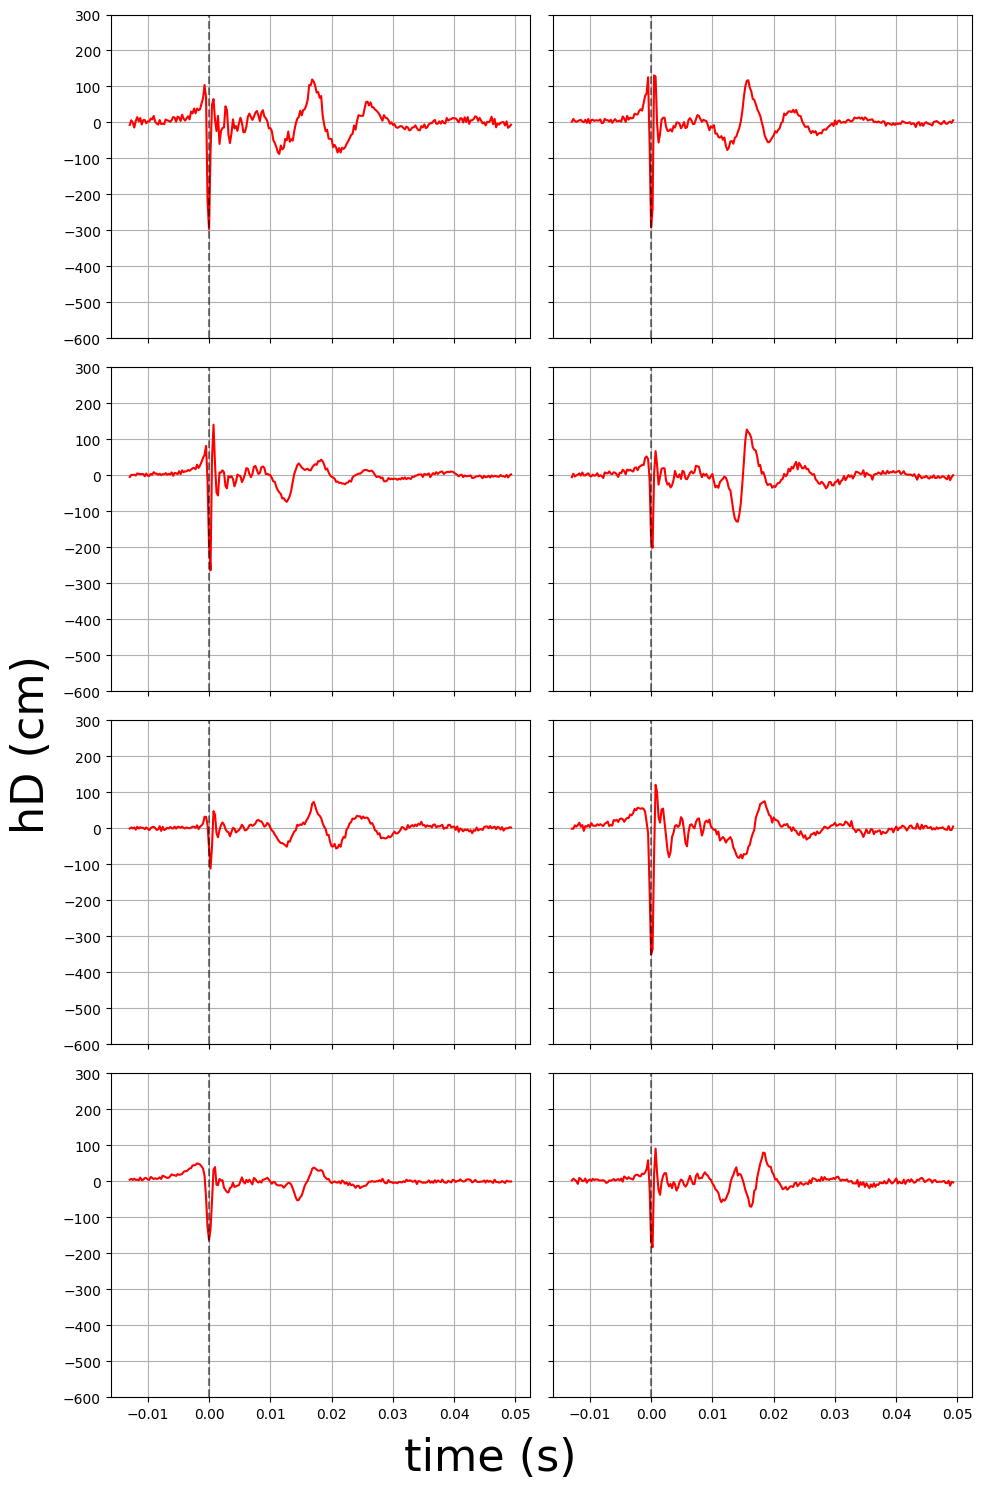

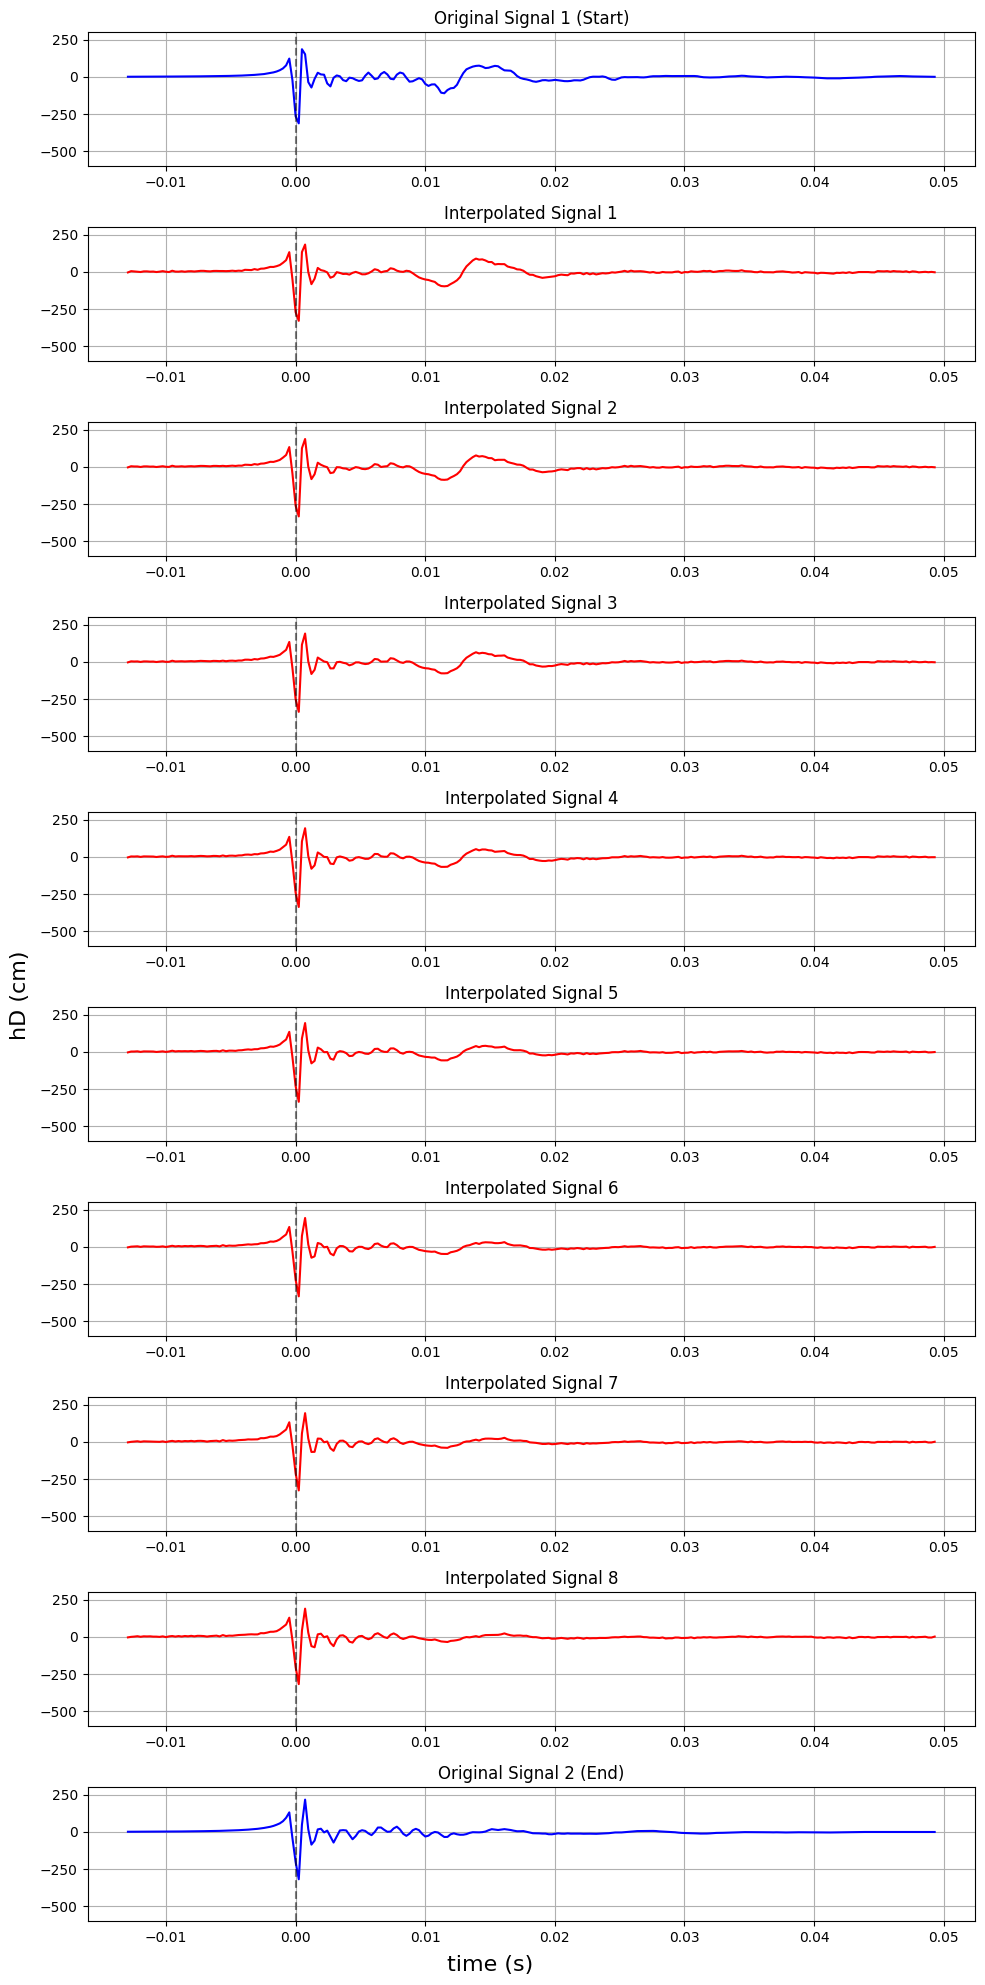

Epoch 21 complete! 	Average Loss: 38.5726, Validation Loss: 42.1623
Epoch 22 complete! 	Average Loss: 38.4592, Validation Loss: 42.7871
Epoch 23 complete! 	Average Loss: 37.7566, Validation Loss: 42.3880
Epoch 24 complete! 	Average Loss: 37.9633, Validation Loss: 43.7038
Epoch 25 complete! 	Average Loss: 37.1424, Validation Loss: 41.8729
Epoch 26 complete! 	Average Loss: 37.1236, Validation Loss: 41.4167
Epoch 27 complete! 	Average Loss: 36.5650, Validation Loss: 40.8887
Epoch 28 complete! 	Average Loss: 36.0620, Validation Loss: 41.0075
Epoch 29 complete! 	Average Loss: 36.3116, Validation Loss: 40.7895
Epoch 30 complete! 	Average Loss: 35.8080, Validation Loss: 40.1991


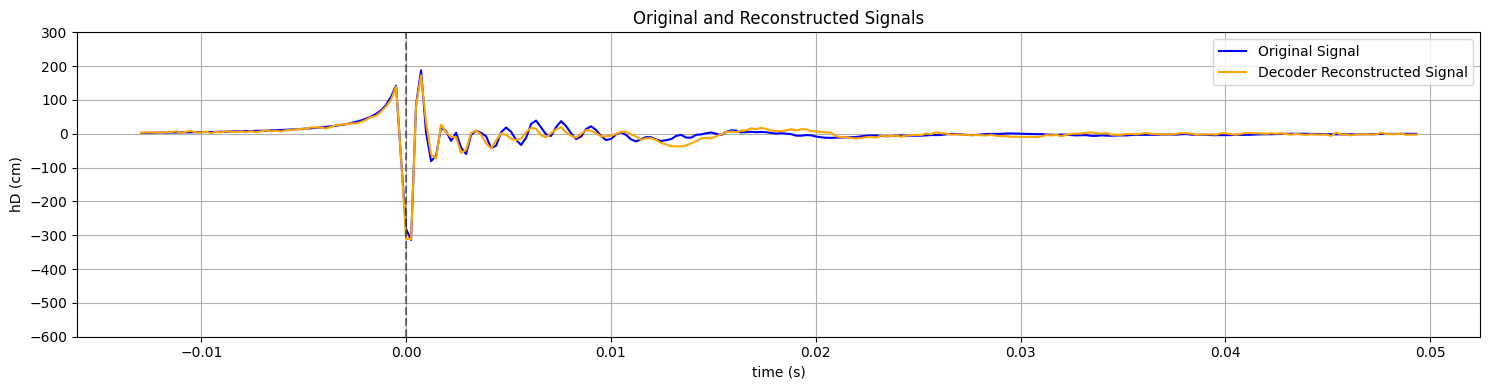

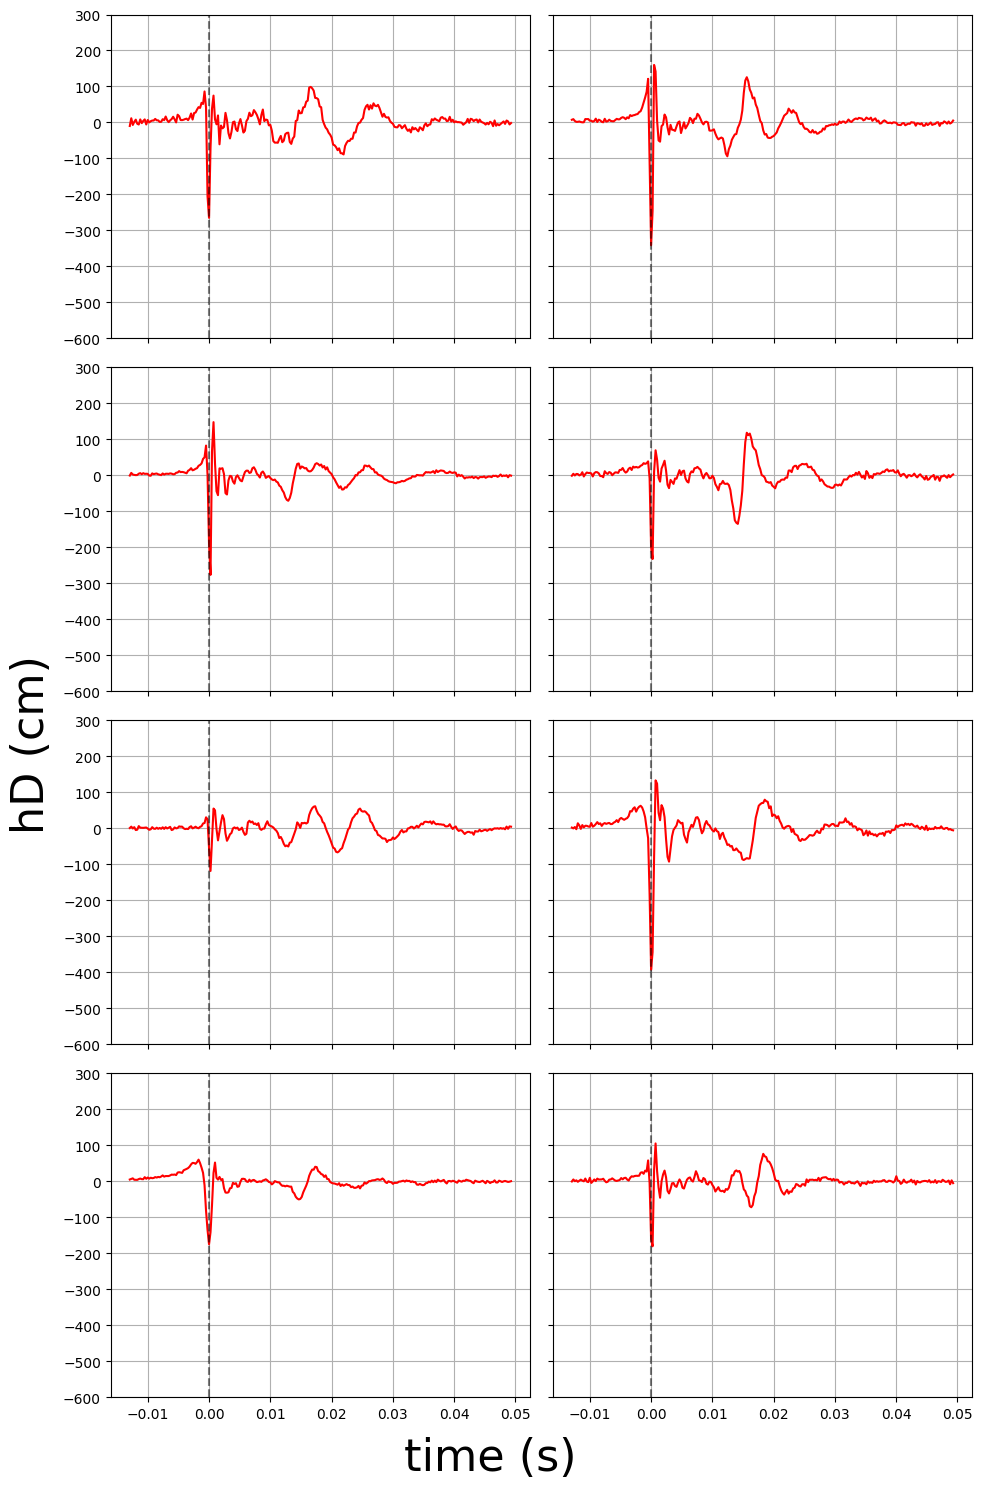

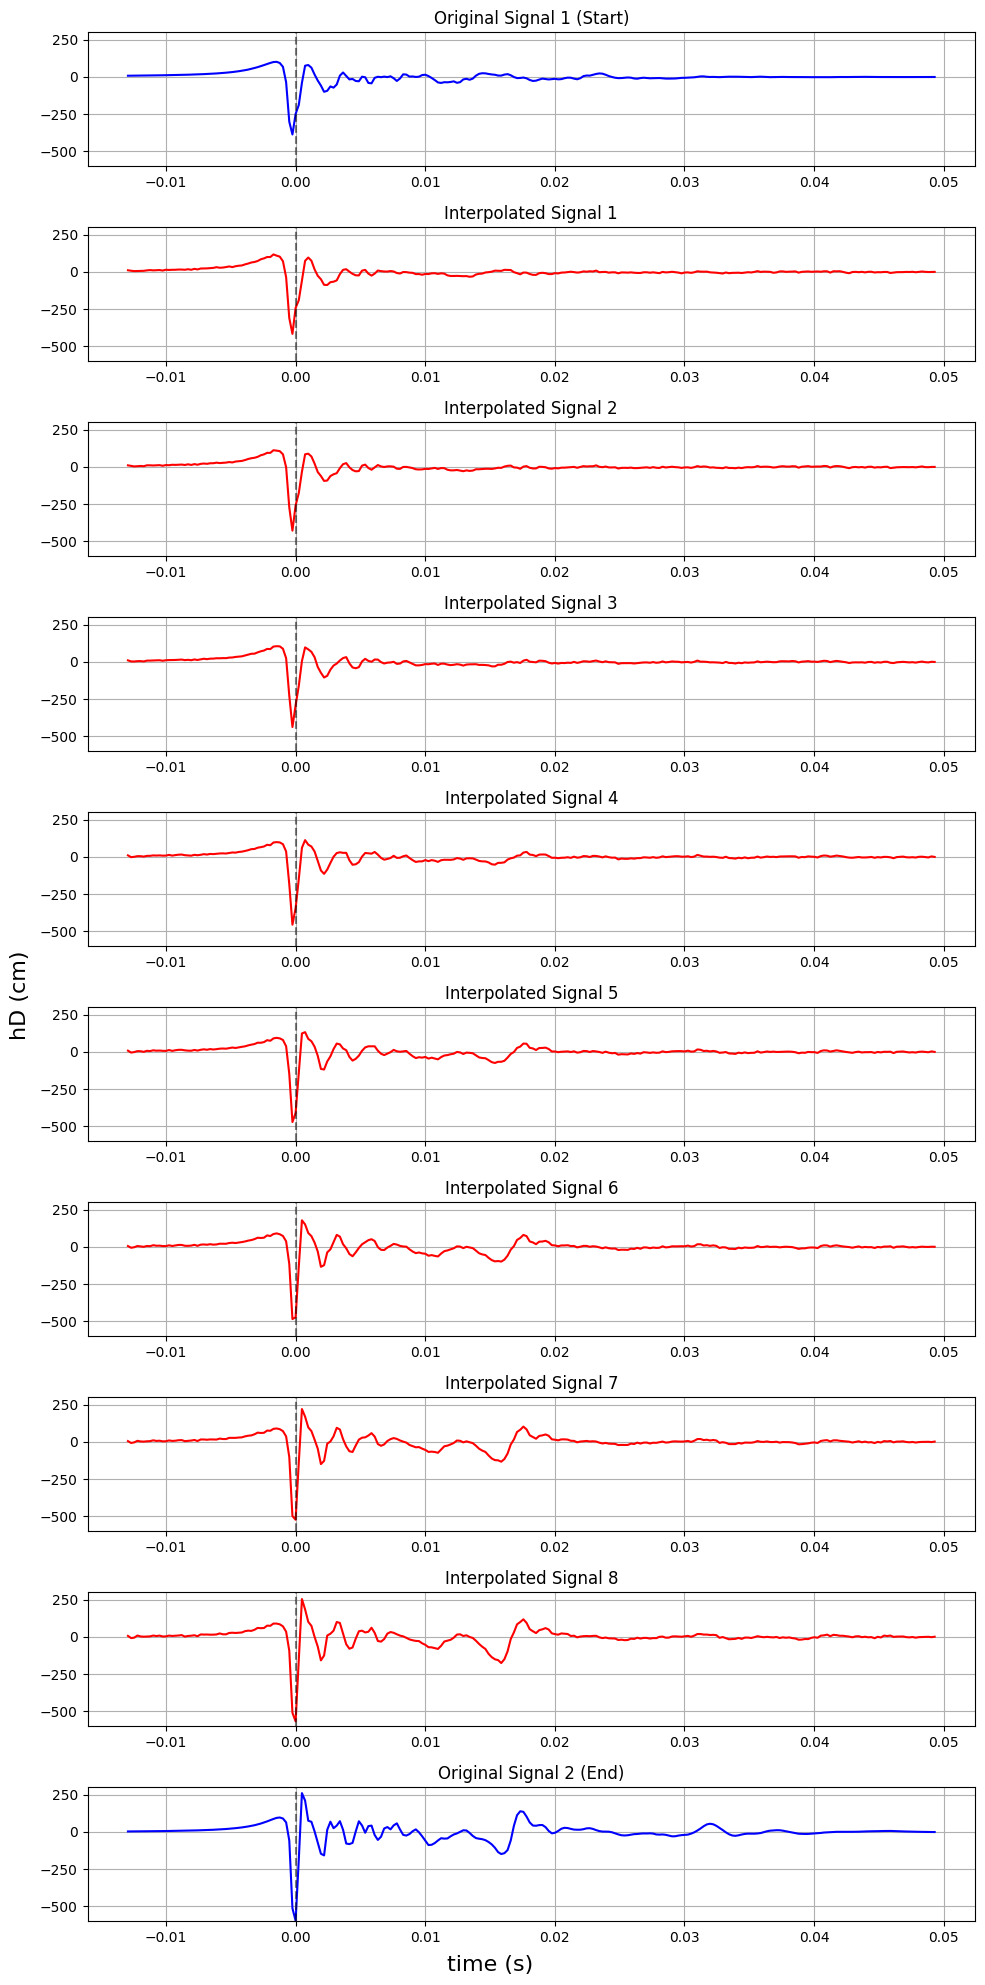

Epoch 31 complete! 	Average Loss: 35.0071, Validation Loss: 39.4221
Epoch 32 complete! 	Average Loss: 35.2483, Validation Loss: 40.0656


KeyboardInterrupt: 

In [10]:
print("Start training VAE...")
model.train()

avg_total_losses = []
avg_reproduction_losses = []
avg_KLDs = []

avg_total_losses_validation = []
avg_reproduction_losses_validation = []
avg_KLDs_validation = []

noise = torch.randn(batch_size, latent_dim).to(DEVICE)

# validation data for validation
validation_data = []
for data in validation_dataloader:
    validation_data.append(data.to(DEVICE))
validation_data = torch.cat(validation_data, dim=0)

for epoch in range(epochs):
    overall_total_loss = 0
    overall_reproduction_loss = 0
    overall_KLD = 0

    overall_total_loss_validation = 0
    overall_reproduction_loss_validation = 0
    overall_KLD_validation = 0

    total_samples = 0

    for batch_idx, x in enumerate(train_dataloader, 0):
        x = x.view(x.size(0), -1)  # Reshape to (batch_size, 256) if needed
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        total_loss, reproduction_loss, KLD = loss_function(x, x_hat, mean, log_var)
        
        overall_total_loss += total_loss.item()
        overall_reproduction_loss += reproduction_loss.item()
        overall_KLD += KLD.item()
        total_samples += x.size(0)

        total_loss.backward()
        optimizer.step()

        # validation losses
        with torch.no_grad():
            x_validation = validation_data
            x_validation = x_validation.view(x_validation.size(0), -1).to(DEVICE)
            x_hat_validation, mean_validation, log_var_validation = model(x_validation)
            total_loss_validation, reproduction_loss_validation, KLD_validation = loss_function(x_validation, x_hat_validation, mean_validation, log_var_validation)

    # summarise training losses
    avg_total_loss = overall_total_loss / total_samples
    avg_reproduction_loss = overall_reproduction_loss / total_samples
    avg_KLD = overall_KLD / total_samples

    avg_total_losses.append(avg_total_loss)
    avg_reproduction_losses.append(avg_reproduction_loss)
    avg_KLDs.append(avg_KLD)

    # summarise validation losses
    avg_total_loss_validation = total_loss_validation.item() / x_validation.size(0)
    avg_reproduction_loss_validation = reproduction_loss_validation.item() / x_validation.size(0)
    avg_KLD_validation = KLD_validation.item() / x_validation.size(0)

    avg_total_losses_validation.append(avg_total_loss_validation)
    avg_reproduction_losses_validation.append(avg_reproduction_loss_validation)
    avg_KLDs_validation.append(avg_KLD_validation)

    print(f"Epoch {epoch + 1} complete! \tAverage Loss: {avg_total_loss:.4f}, Validation Loss: {avg_total_loss_validation:.4f}")

    if (epoch + 1) % 10 == 0:
        x = x.cpu().detach()
        x_hat = x_hat.cpu().detach()
        plot_reconstruction(x[0], x_hat[0], max_value=train_dataset.max_value)

        with torch.no_grad():
            generated_signals = decoder(noise).cpu().detach().numpy()
        
        plot_waveform_grid(signals=generated_signals, max_value=train_dataset.max_value)

        idx1 = torch.randint(0, x.size(0), (1,)).item()
        idx2 = idx1

        while idx2 == idx1: # ensures we don't sample the same signal
            idx2 = torch.randint(0, x.size(0), (1,)).item()

        signal_1 = x[idx1].to(DEVICE)
        signal_2 = x[idx2].to(DEVICE)
        
        plot_latent_morphs(encoder, decoder, signal_1, signal_2, max_value=train_dataset.max_value, steps=8)

print("Training finished!")

### Training and Validation Loss

In [ ]:
plot_training_validation_loss(avg_total_losses, avg_total_losses_validation)

### Morph Between Two Signals